In [9]:

import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scipy.stats as stats
from scipy.integrate import quad
from scipy.special import erf
from scipy.special import expi
from common_functions import CurvedText
import common_functions as cf


In [10]:
#### Comparing the probability of establishment and fixation for new and segregating alleles of a constant effect size #####

# set the font size for all elements in the plots to be 11
matplotlib.rcParams.update({'font.size': 11})


In [11]:
### Common functions to describe the steady state distribution of allele frequencies ###
def variance_star(a,x,N):
    return 2*a**2*x*(1-x)

def folded_sojourn_time(a,x,N):
    if x < 1/(2*N):
        factor = 2*N
    else:
        factor = 1/x
    
    return factor * 2 * np.exp(-variance_star(a,x,N)/2) / (1-x)


In [12]:
# Calculate the probability of establishment given starting frequency x and an effect size a and shift in optimum
def establishment_prob_given_x(a,N,shift,x):
    s0 = a/(2*N)*(shift - a*(1/2-x))
    if s0 <= 0:
        return 0
    else:
        return (1 - np.exp(-4*N*x*s0))/(1-np.exp(-4*N*s0))
    
# Calculate the overall probability of establishment for a segregating allele with effect size a and shift in optimum
def establishment_prob_segregating(a,N,shift):
    numerator_integrand = lambda x: folded_sojourn_time(a,x,N) * establishment_prob_given_x(a,N,shift,x)
    denominator_integrand = lambda x: folded_sojourn_time(a,x,N)
    numerator_integral, _ = quad(numerator_integrand, 0, 1/2, points = [1/(2*N)])
    denominator_integral, _ = quad(denominator_integrand, 0, 1/2, points = [1/(2*N)])
    return numerator_integral/denominator_integral

# Analytic approximation to the probability of establishment for a segregating allele with effect size a and shift in optimum
def establishment_prob_segregating_analytic(a,N,shift):
    x_est = 1/(2*a*(shift - a/2))
    x_msdb = 1/(a**2)
    if shift <= a/2:
        return 0
    C = 2/quad(lambda x: folded_sojourn_time(a,x,N),0,1/2,points=[1/(2*N)])[0]
    h1 = lauras_function(1/(2*x_msdb)+1/(2*x_est))
    h2 = lauras_function(1/(2*x_msdb))
    return max(0,C*(np.log(1+x_msdb/x_est)))

# Calculate the overall probability of establishment for a new mutation with effect size a and shift in optimum
def establishment_prob_new(a,N,shift,sigma2):
    x = 1/(2*N)
    if shift <= a/2:
        return 0
    t_est = max(1,2*N/sigma2*np.log(2*shift/a))
    t_max = 2*N/sigma2*np.log(shift)
    numerator_integrand = lambda t: establishment_prob_given_x(a,N,shift*np.exp(-sigma2*t/(2*N)),x)
    integral, _ = quad(numerator_integrand, 0, t_est)
    return integral/t_max

# Analytic approximation to the probability of establishment for a new mutation with effect size a and shift in optimum
def lauras_function(y):
    return -expi(-y)

def establishment_prob_new_analytic(a,N,shift,sigma2):
    if shift <= a/2:
        return 0
    
    helper1 = np.log(2*shift/a)
    helper2 = np.log(shift)
    helper3 = lauras_function(a**2/(2*N))-lauras_function(2*a*shift/(2*N))
    helper4 = np.exp(a**2/(2*N))
    return helper1/helper2-helper3*helper4/helper2

### Plotting functions ###
def plot_establishment_prob_segregating(ax,a,N,shift_values):
    establishment_probs = [establishment_prob_segregating(a,N,shift) for shift in shift_values]
    ax.plot(shift_values/a, establishment_probs, label = 'Eq. S14 (numeric)', color = 'grey')
    
    establishment_probs_analytic = [establishment_prob_segregating_analytic(a,N,shift) for shift in shift_values]
    ax.plot(shift_values/a, establishment_probs_analytic, '--', label = 'Eq. S15', color = 'cornflowerblue')
    ax.set_xlabel(r'Shift size relative to $a$ ($\Lambda/a$)')
    ax.set_ylabel('Probability')
    ax.set_title(r'$\bf{A.}$ Establishment probability: segregating')
    ax.set_xlim(0,100/a)
    ax.legend(handlelength=1,edgecolor='black')

def plot_establishment_prob_new(ax,a,N,shift_values,sigma2):
    establishment_probs = [establishment_prob_new(a,N,shift,sigma2) for shift in shift_values]
    ax.plot(shift_values/a, establishment_probs, label = 'Eq. S30 (numeric)', color = 'grey')
    establishment_probs_analytic = [establishment_prob_new_analytic(a,N,shift,sigma2) for shift in shift_values]
    # plot this but with a custom dash so the dashes are more spread ou
    ax.plot(shift_values/a, establishment_probs_analytic, label = 'Eq. S30 (analytic)', color = 'cornflowerblue', dashes=(5, 7))
    
    ax.set_xlabel(r'Shift size relative to $a$ ($\Lambda/a$)')
    ax.set_ylabel('Probability')
    ax.set_title(r'$\bf{B.}$ Establishment probability: new')
    ax.legend(handlelength=1,edgecolor='black')
    ax.set_xlim(0,100/a)


In [13]:
# calculate the probability of fixation for a segregating allele with effect size a and shift in optimum
# these functions implement the double recursion described in the supplement
def calculate_expected_change_in_freq(a,x,N,D):
    return a*x*(1-x)/(2*N)*(D-a*(1/2-x))

def recursion_determinsitic(a,x0,shift,sigma2,N):
    x = x0
    D = shift
    while x > x0/10 and x < 1/2:
        dx = calculate_expected_change_in_freq(a,x,N,D)
        x += dx
        D -= dx*2*a
        D -= D*sigma2/(2*N)
        if dx < 0:
            return 0
        elif x > 1/2:
            return 1
    if x < 1/2:
        return 0
    else:
        return 1

# Recursive function to find the critical frequency x_c using bisection
def find_xc(a,sigma2,N,shift,x_min,x_max,x_current):
    
    recursion_outcome = recursion_determinsitic(a,x_current,shift,sigma2,N)
    
    if recursion_outcome == 1:
        x_max = x_current
    elif recursion_outcome == 0:
        x_min = x_current
    
    if x_max - x_min > 1e-6:
        x_current = (x_max + x_min)/2
        return find_xc(a,sigma2,N,shift,x_min,x_max,x_current)
    else:
        return (x_max + x_min)/2
    
# Calculate the overall probability of fixation for a segregating allele with effect size a and shift in optimum
# using the critical frequency x_c found by recursion
def calculate_prob_fixation(a,sigma2,N,shift):
    x_c = find_xc(a,sigma2,N,shift,0,1/2,1/4)
    numerator = quad(lambda x: folded_sojourn_time(a=a,x=x,N=N) * establishment_prob_given_x(a=a,N=N,shift=shift,x=x), x_c, 1/2, points = [1/(2*N)])[0]
    denominator = quad(lambda x: folded_sojourn_time(a=a,x=x,N=N), 0, 1/2,points=[1/(2*N)])[0]
    return numerator/denominator

# Analytic approximation to the probability of fixation for a segregating allele with effect size a and shift in optimum
def prob_fixation_analytic(a,sigma2,N,shift):
    x_est = 1/(2*a*(shift - a/2))
    x_c = np.exp(-a*(shift-a)/sigma2)
    x_msdb = 1/(a**2)
    C = 2/quad(lambda x: folded_sojourn_time(a,x,N),0,1/2,points=[1/(2*N)])[0]
    h1 = lauras_function(x_c/x_msdb)
    h2 = lauras_function(x_c/x_msdb+x_c/x_est)
    return max(0,C*(h1-h2))

# Analytic approximations corresponding to equations S25 and S26 in the supplement
def prob_fixation_analytic_s25(a,sigma2,N,shift):
    x_est = 1/(2*a*(shift - a/2))
    x_c = np.exp(-a*(shift-a)/sigma2)
    x_msdb = 1/(a**2)
    C = 2/quad(lambda x: folded_sojourn_time(a,x,N),0,1/2,points=[1/(2*N)])[0]
    return C*(np.log(1+x_msdb/x_est-x_c/x_est))

def prob_fixation_analytic_s26(a,sigma2,N,shift):
    x_est = 1/(2*a*(shift - a/2))
    x_c = np.exp(-a*(shift-a)/sigma2)
    x_msdb = 1/(a**2)
    C = 2/quad(lambda x: folded_sojourn_time(a,x,N),0,1/2,points=[1/(2*N)])[0]
    f = 1/3
    return C*(1/(f+x_est/x_msdb))*np.exp(-x_c/x_est*(f+x_est/x_msdb))

# Plotting function for fixation probability of segregating allele
def plot_fixation_prob_segregating(ax,a,N,sigma2,fontsize):
    shift_values = np.linspace(0,100,201)    
    a = 14
    y_values = [calculate_prob_fixation(a=a,N=N,shift=shift,sigma2=sigma2) for shift in shift_values]
    y_values_analytic = [prob_fixation_analytic(a=a,N=N,shift=shift,sigma2=sigma2) for shift in shift_values]
    y_values_analytic_s25 = [prob_fixation_analytic_s25(a=a,N=N,shift=shift,sigma2=sigma2) for shift in shift_values]
    y_values_analytic_s26 = [prob_fixation_analytic_s26(a=a,N=N,shift=shift,sigma2=sigma2) for shift in shift_values]

    # find the first index where y_values_analytic_s25 is closest to y_values_analytic_s26 and the shift value is greater than 30
    for i in range(len(shift_values)):
        if shift_values[i] > 30 and abs(y_values_analytic_s25[i] - y_values_analytic_s26[i]) < 0.001:
            # print(shift_values[i], y_values_analytic_s25[i], y_values_analytic_s26[i])
            break


    # ax.plot(shift_values/a,y_values,label='Double recursion',color='grey',lw=2)
    # ax.plot(shift_values/a,y_values_analytic,'-',color='cornflowerblue',label='Eq. S26',lw=2)
    # ax.plot(shift_values[:i]/a,y_values_analytic_s26[:i],':',label='Eq. S27',color='orange',lw=2)
    # ax.plot(shift_values[i:]/a,y_values_analytic_s25[i:],'--',label='Eq. S28',color='brown',lw=2)
    
    for initial_x,x,y,label_text,color,ls,zorder in zip([2.1,4.9,3,3],
                                              [shift_values[:i]/a,shift_values[i:]/a,shift_values/a,shift_values/a],
                                              [y_values_analytic_s26[:i],y_values_analytic_s25[i:],y_values_analytic,y_values],
                                              ['Eq. S28','Eq. S27','Eq. S26','Double recursion'],
                                              ['orange','brown','cornflowerblue','grey'],
                                              [':','--','-','-'],
                                              [10,10,9,10]):
        ax.plot(x,y,ls=ls,color=color,lw=2,zorder=zorder)
        x_t = []
        y_t = []
        for xx,yy in zip(x,y):
            if xx >= initial_x:
                x_t.append(xx)
                y_t.append(yy)
        y_t = np.array(y_t)
        x_t = np.array(x_t)
        if 'Eq.' in label_text:
            y_t += 0.03
            if color == 'orange':
                x_t -= 0.1
        else:
            y_t -= 0.04
            x_t += 0.3
        
        CurvedText(x=x_t,y=y_t,text=label_text,color=color,axes=ax)
        
    # ax.legend(handlelength=1,edgecolor='black',fontsize=fontsize)
    ax.set_ylim(0,0.7)
    ax.set_xlim(0,100/a)
    ax.set_xlabel(r'Shift size relative to $a$ ($\Lambda/a$)',fontsize=fontsize)
    ax.set_ylabel('Probability',fontsize=fontsize)
    ax.set_title(r'$\bf{A.}$ Fixation probability: segregating',fontsize=fontsize)


In [14]:
# calculate the probability of fixation for a new mutation with effect size a and shift in optimum
# these functions use the double recursion described in the supplement
# Recursive function to find the critical time t_c using bisection
def find_tc(a,shift,sigma2,N,t_min,t_max,t_current):
    
    recursion_outcome = recursion_determinsitic(a=a,x0=1/(2*N),shift=shift*np.exp(-sigma2*t_current/(2*N)),sigma2=sigma2,N=N)
    
    if recursion_outcome == 1:
        t_min = t_current
    elif recursion_outcome == 0:
        t_max = t_current
    if t_max - t_min > 1e-6:
        t_current = (t_max + t_min)/2
        return find_tc(a,shift,sigma2,N,t_min,t_max,t_current)
    else:
        return (t_max + t_min)/2

# Calculate the overall probability of fixation for a new mutation with effect size a and shift in optimum
# using the critical time t_c found by recursion
def calculate_prob_fixation_new(a,shift,sigma2,N):
    t_c = find_tc(a,shift,sigma2,N,0,2*N/sigma2*np.log(shift),N/sigma2)
    if t_c <= 0:
        return 0
    numerator_integrand = lambda t: establishment_prob_given_x(a=a,N=N,shift=shift*np.exp(-sigma2*t/(2*N)),x=1/(2*N))
    numerator = quad(numerator_integrand, 0, t_c)[0]
    denominator = 2*N/sigma2*np.log(shift)
    return numerator/denominator

# Analytic approximation to the probability of fixation for a new mutation with effect size a and shift in optimum
def prob_fixation_analytic_new(a,shift,sigma2,N):
    
    if shift <= np.log(2*N)*sigma2/a+a:
        return 0
    helper0 = np.log(2*N)*sigma2/a+a
    helper1 = lauras_function(2*a/(2*N)*helper0)-lauras_function(2*a/(2*N)*shift)
    helper2 = np.exp(a**2/(2*N))
    helper3 = np.log(shift/helper0)
    helper4 = np.log(shift)
    return 1/helper4*(helper3-helper1*helper2)

# Plotting function for fixation probability of new mutation
def plot_fixation_prob_new(ax,a,N,sigma2,fontsize=12):
    shift_values = np.linspace(0,100,201)
    y_values = [calculate_prob_fixation_new(a=a,shift=shift,sigma2=sigma2,N=N) for shift in shift_values]
    y_values_analytic = [prob_fixation_analytic_new(a=a,shift=shift,sigma2=sigma2,N=N) for shift in shift_values]
    
    for initial_x,x,y,label_text,color,ls,zorder in zip([4.3,4],
                                              [shift_values/a,shift_values/a],
                                              [y_values_analytic,y_values],
                                              ['Eq. S33','Double recursion'],
                                              ['cornflowerblue','grey'],
                                              ['-','-'],
                                              [10,10]):
        
        ax.plot(x,y,ls=ls,color=color,lw=2,zorder=zorder)
        x_t = []
        y_t = []
        for xx,yy in zip(x,y):
            if xx >= initial_x:
                x_t.append(xx)
                y_t.append(yy)
        y_t = np.array(y_t)
        x_t = np.array(x_t)
        if 'Eq.' in label_text:
            y_t += 0.003
            if color == 'orange':
                x_t -= 0.1
        else:
            y_t -= 0.004
            x_t += 0.2
        
        CurvedText(x=x_t,y=y_t,text=label_text,color=color,axes=ax)
        
    # ax.plot(shift_values/a,y_values,label='Double recursion',color='grey',lw=2)
    # ax.plot(shift_values/a,y_values_analytic,'-',label='Eq. S33',color='cornflowerblue',lw=2)
    # ax.legend(handlelength=1,edgecolor='black')
    ax.set_ylim(0,0.04)
    ax.set_xlim(0,100/a)
    ax.set_yticks([0,0.01,0.02,0.03,0.04])
    ax.set_xlabel(r'Shift size relative to $a$, ($\Lambda/a$)',fontsize=fontsize)
    ax.set_ylabel('Probability',fontsize=fontsize)
    ax.set_title(r'$\bf{B.}$ Fixation probability: new',fontsize=fontsize)


/local/ipykernel_658708/631629650.py:49: RuntimeWarning: divide by zero encountered in scalar divide
  x_est = 1/(2*a*(shift - a/2))
/local/ipykernel_658708/631629650.py:59: RuntimeWarning: divide by zero encountered in scalar divide
  x_est = 1/(2*a*(shift - a/2))
/local/ipykernel_658708/631629650.py:63: RuntimeWarning: invalid value encountered in log
  return C*(np.log(1+x_msdb/x_est-x_c/x_est))
/local/ipykernel_658708/631629650.py:66: RuntimeWarning: divide by zero encountered in scalar divide
  x_est = 1/(2*a*(shift - a/2))
/local/ipykernel_658708/631629650.py:71: RuntimeWarning: invalid value encountered in scalar multiply
  return C*(1/(f+x_est/x_msdb))*np.exp(-x_c/x_est*(f+x_est/x_msdb))
/local/ipykernel_658708/3274226669.py:21: RuntimeWarning: divide by zero encountered in log
  t_c = find_tc(a,shift,sigma2,N,0,2*N/sigma2*np.log(shift),N/sigma2)
/local/ipykernel_658708/3274226669.py:26: RuntimeWarning: divide by zero encountered in log
  denominator = 2*N/sigma2*np.log(shift)


Adjusting figure width from 6.50 to 6.85 inches to achieve target width of 6.50 inches.


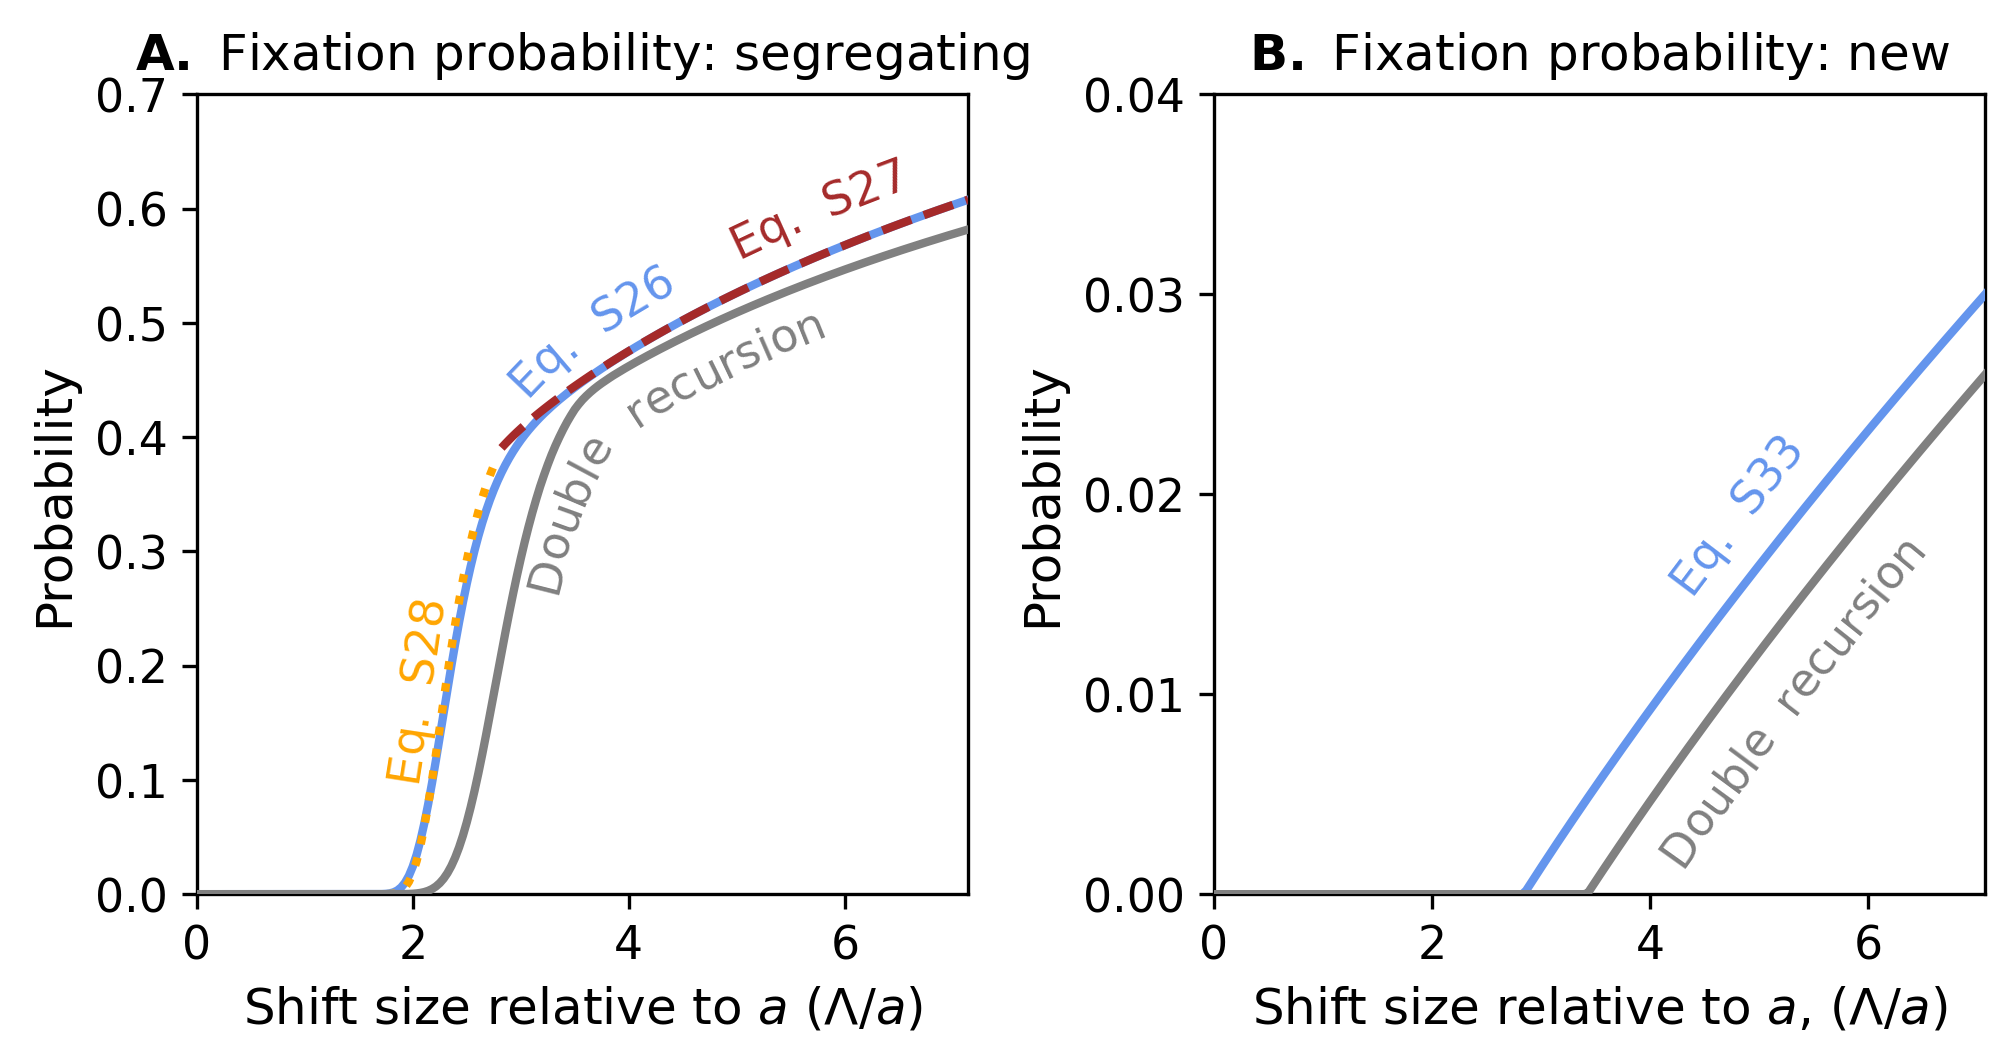

In [15]:
### Make figure S4 ###

def make_figure_s4(fig_height,fig_width,sigma2=40,N=5000,a=np.sqrt(200),fontsize=12):
    fig,axes = plt.subplots(figsize=(fig_width,fig_height),dpi=300,ncols=2)
    plot_fixation_prob_segregating(axes[0],a=a,N=N,sigma2=sigma2,fontsize=fontsize)
    plot_fixation_prob_new(axes[1],a=a,N=N,sigma2=sigma2,fontsize=fontsize)
    plt.tight_layout()
    bbox = axes[0].get_window_extent().transformed(fig.dpi_scale_trans.inverted())
    width_inches, height_inches = bbox.width, bbox.height
    return fig, fig_width, fig_height, width_inches, height_inches

height = 3.362289076956597
filename = './Figures/Figure_S4.png'
cf.make_figure_set_width(fig_function=make_figure_s4,fig_width=6.5,fig_height=height,target_width_inches=6.5,filename=filename,sigma2=40,N=5000,a=np.sqrt(200),fontsize=12)
